# Minodes Classification Challenge

The data set at hand contains gathered signals of WiFi routers (nodes) distributed in a mall. The signals are probe requests emitted by smartphones which have been carried around various pre-defined zones within the mall. In the data set the corresponding zone has been linked with the respective signal strengths received by surrounding nodes. The signal strength is provided in relative amplitude decay on logarithmic scale (decibel).

Aim of the challenge is to build and validate a classifier, that predicts the corresponding zone based on the signals received by the nodes. Given 449 unique zones this challenge poses an extensive multiclass classification task.

## Load Libraries and Data

In [1]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import ast
import numpy as np
import seaborn as sns
import time
from scipy.sparse import csr_matrix

In [2]:
df=pd.read_csv('data/fingerprints_gt_ver3.csv')

In [3]:
df.head(5)

,fr_observation_time,fr_values,fr_mac_address_id,zo_name
0,2015-12-08 10:00:13,"{'12': '-69', '33': '-61', '128': '-68', '276'...",2002427,Zone 355
1,2015-12-08 10:00:13,"{'9': '-83', '13': '-67', '33': '-62', '101': ...",3192369,Zone 355
2,2015-12-08 10:00:14,"{'9': '-83', '10': '-77', '11': '-85', '12': '...",2002427,Zone 355
3,2015-12-08 10:00:14,"{'9': '-86', '10': '-83', '11': '-87', '12': '...",3192369,Zone 355
4,2015-12-08 10:00:15,"{'10': '-76', '11': '-86', '12': '-65', '13': ...",480806,Zone 355


Fingerprint is in dictionary format and string encoded in column *fr_values*. Fill missing values with $-100$ and cast as *int16* which is more than enough for $x\in\mathbb{N}, [-100,0]$.

In [4]:
df_fp=pd.DataFrame.from_records(df.fr_values.apply(ast.literal_eval))\
                  .fillna(-100)\
                  .astype('int16')

## Some EDA

### Number of received signals

Lets take a quick glance on the data.

In [5]:
df_fp.head()

,1,10,101,102,103,104,105,107,109,11,...,89,9,90,91,92,93,94,97,98,99
0,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
1,-100,-100,-64,-100,-100,-100,-100,-100,-100,-100,...,-100,-83,-100,-100,-100,-100,-100,-100,-100,-100
2,-100,-77,-69,-71,-100,-100,-100,-100,-100,-85,...,-100,-83,-100,-100,-100,-100,-100,-100,-79,-74
3,-100,-83,-65,-100,-100,-100,-100,-100,-100,-87,...,-100,-86,-100,-100,-100,-100,-100,-100,-100,-80
4,-100,-76,-65,-100,-100,-100,-100,-100,-100,-86,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100


It appears that most of the signals are at -100 which corresponds to "out of receiption range". Let's quantifiy this a little bit more by plotting the distribution of number of received signals per sample in the data set.

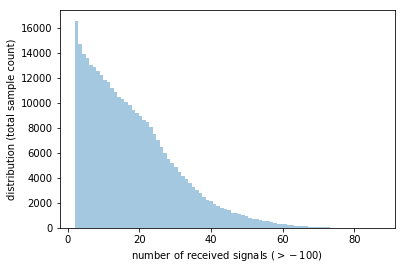

In [161]:
values=(df_fp>-100).transpose().sum()

sns.distplot(values, kde=False, norm_hist=False, bins=test.max()-1)
plt.xlabel('number of received signals ($>-100$)')
plt.ylabel('distribution (total sample count)')
plt.show()

In [166]:
print('Count of samples where only one signal was received:', (values==1).sum())

Count of samples where only one signal was received: 0


As indicated by the data, the majority of the samples received signals from less than 20 out of the 261 nodes. Interestingly, samples with only one received signal do not exist and have likely been removed.

Lets plot the same distribution splitted up for the 5 different zones with the highest number of samples in the data set:

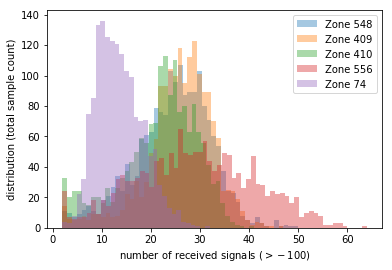

In [170]:
for i, label in enumerate(df.zo_name.value_counts().index[:5]):
    values=(df_fp[df.zo_name==label]>-100).transpose().sum()
    sns.distplot(values,  label=label, bins=values.max()-1, kde=False)
plt.xlabel('number of received signals ($>-100$)')
plt.ylabel('distribution (total sample count)')
plt.legend()

As expected and indicated by the figure, different zones receive on average different numbers of signals. This property can be used to include signal counts, i.e., *sum(lambda s: s>-100) for s in sample*, as additional feature in the model.

### Signal strength

Now let us investigate the signal itself. First we draw a distribution for all signals (>-100) in the data set.

Text(0,0.5,'distribution (total sample count)')

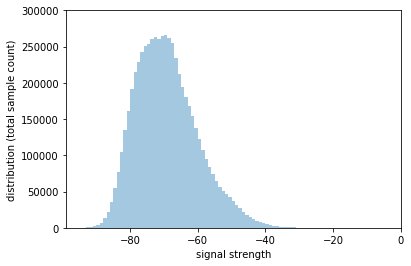

In [172]:
values=df_fp.values.reshape(-1,)
sns.distplot(values, kde=False, norm_hist=False, bins=100+values.max())
plt.xlim([-99,0])
plt.ylim([0, 3e5])
plt.xlabel('signal strength')
plt.ylabel('distribution (total sample count)')

In [173]:
print('Strongest signal received:', values.max())

Strongest signal received: -13


The signal strength follows a distribution centered around ~-70dB. Signals stronger than -13dB have not been received in this data set.

Analog to before, we split the distribution down to 5 zones with high sample count:

(0, 2000.0)

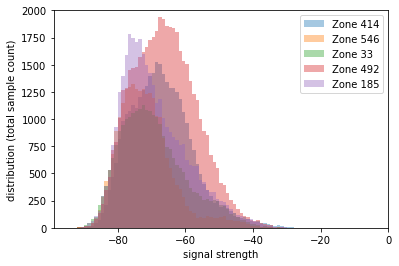

In [174]:
for i, label in enumerate(df.zo_name.value_counts().index[5:10]):
    values=df_fp[df.zo_name==label].values.reshape(-1,)
    sns.distplot(values,  label=label, bins=100+values.max(), kde=False)
plt.xlabel('signal strength')
plt.ylabel('distribution (total sample count)')    
plt.legend()
plt.xlim([-99,0])
plt.ylim([0, 2e3])

Also here we see deviations of e.g., width, x-shift, within the distribution for different zones. To utilize this in our model the data can be enriched by *f*=*max()*, *min()*, *mean()*, *sum()*, *std()* in *f(lambda s: s>-100) for s in sample*.

### Data quality

How many samples exist in each zone? Let us investigate and plot the top 50 and the bottom 50 zones.

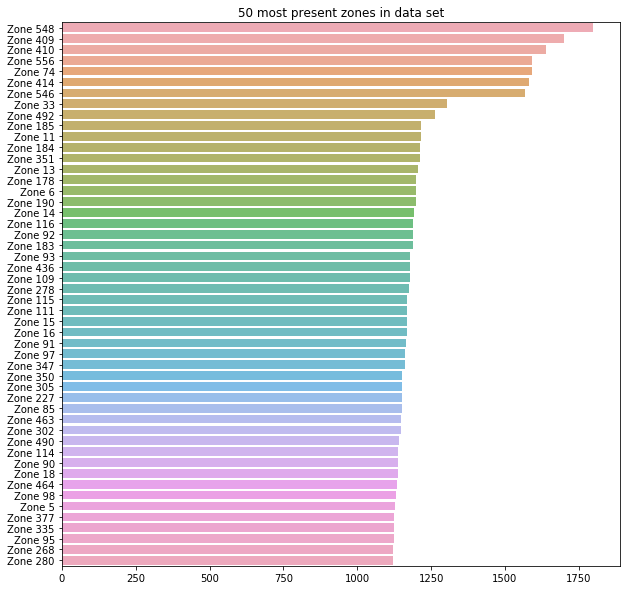

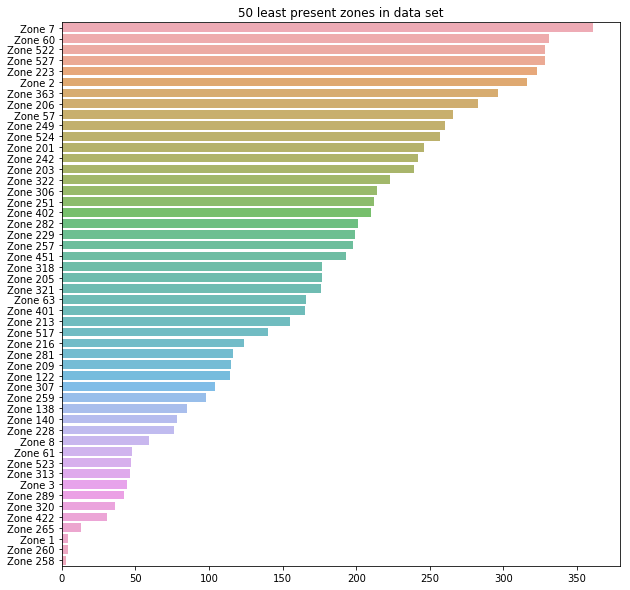

In [185]:
zone_sample_count=df['zo_name'].value_counts()[:50]

plt.figure(figsize=(10,10))
sns.barplot(zone_sample_count.values, zone_sample_count.index, alpha=0.8)
plt.title('50 most present zones in data set')

zone_sample_count=df['zo_name'].value_counts()[-50:]

plt.figure(figsize=(10,10))
sns.barplot(zone_sample_count.values, zone_sample_count.index, alpha=0.8)
plt.title('50 least present zones in data set')

plt.show()

Across the broad majority of the zones enough samples have been gathered to train a model. However, for the last 10 and particulary last three of the zones only <50 samples and <5 samples, respectively exist. For so little data leave-one-out validation schemes can be applied but deliver only a vague estimate of model performance. In this particular use-case gathering additional data for the underpresented zones should be the cost-effective alternative.

Displaying the data set in terms of gathered samples for various mac id's yields the following plot:

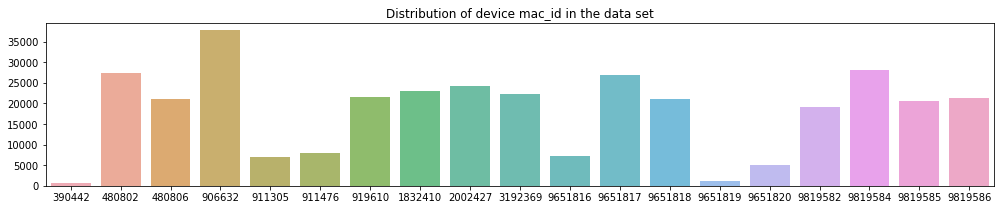

In [189]:
id_sample_count=df.fr_mac_address_id.value_counts()

plt.figure(figsize=(17,3))
sns.barplot(id_sample_count.index, id_sample_count.values, alpha=0.8)
plt.title('Distribution of device mac_id in the data set')

plt.show()

Technically, a machine learning model can take into account the mac_id and thus capture additional device-specific effects which might improve the model. This can be done as additional categorical feature or even mac_id dependent model. Practically, data is to little and many zones very likely underrepresented if splitting the data by mac_id. Moreover, the task is to build a model based on the fingerprint only, therefore excluding the mac_id.

## Model Pre-selection

### Data preperation

We can further sparsify the data by adding $100$, thus changing the value range to $[0, 100]$ without changing the physical interpretation of decibel. Because most signals are only received by a hand-full of nodes we can greatly reduce required memory. Additionaly, for each fingerprint signal count, mean, sum, standard deviation and min/max values are added.

In [5]:
from sklearn import base

class SparseEnrichTransformer(base.BaseEstimator, base.TransformerMixin):  
    def transform(self, X):  
        Xdiff=X+100
        XnanT=Xdiff.replace(0, np.nan).transpose()
        signal_std=XnanT.std().values.reshape(-1,1)
        signal_min=XnanT.min().values.reshape(-1,1)
        signal_max=XnanT.max().values.reshape(-1,1)
        signal_sum=XnanT.sum().values.reshape(-1,1)
        signal_mean=XnanT.mean().values.reshape(-1,1)
        signal_count=XnanT.count().values.reshape(-1,1)

        return csr_matrix(np.hstack([Xdiff.values, signal_std, signal_min, signal_max, signal_sum, signal_mean, signal_count]))

Define a wrapper function for the scores:

In [6]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def macro_score(y_true, y_pred, labels=None, cm=False):
    f1=f1_score(y_true, y_pred, average='macro')
    precision=precision_score(y_true, y_pred, average='macro')
    recall=recall_score(y_true, y_pred, average='macro')
        
    return np.array([f1, precision, recall])

I chose a macroscopic average of the binary scores precision, recall and f1. Effectively, this means the scores do not take class inbalance into account. This is based on my assumption that the data set has been generated by a small team of people carrying around smartphones the various zones in the mall, thus not representing actual people traffic during business hours. As a result, each zone contributes equally to the score regardless of how little data has been gathered.

In order to get a quick overview over a sample of classifiers we only use the top 50 represented zones because the full multclass estimation becomes rather slow.

In [7]:
from sklearn.model_selection import train_test_split

mask=df.zo_name.isin(df.zo_name.value_counts().index[:50])

st=SparseEnrichTransformer()

X=st.transform(df_fp[mask])
y=df.zo_name[mask].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

### Estimator benchmark

Let it run for 6 default classifiers using a stratified train-test-split and measuring training & prediction times. Using very different kinds of classifiers, e.g., tree-based, linear, kernel-based, we get a good impression of what model to use.

Given the mathematically compactness of the feature space, KNN might also be a good candidate for a classifier. KNN becomes rather slow in very high dimensional feature space which makes it necessary to chose some dimensionality-reduction scheme prior to the classifier. In this case PCA with 20 components is chosen.

In [26]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

#estimators that support sparse
estimators=[('NBC', MultinomialNB()),\
            ('RFC', RandomForestClassifier()),\
            ('GBC', GradientBoostingClassifier(n_estimators=10)),\
            ('LR', LogisticRegression()),\
            ('LSVC', LinearSVC())]

estimator_score=[]

for name, estimator in estimators:
    
    score=np.array([0.0, 0.0, 0.0])
    start_ts=time.time()
    estimator.fit(X_train, y_train)
    fit_ts=time.time()
    prediction=estimator.predict(X_test)
    pred_ts=time.time()

    score=macro_score(y_test, prediction, cm=False)
    estimator_score.append([name, score[0], score[1], score[2], fit_ts-start_ts, pred_ts-fit_ts])
 

#estimators that do not support sparse
pca=PCA(n_components=50)

X_pca_train=pca.fit_transform(X_train.todense())
X_pca_test=pca.transform(X_test.todense())

knn=('KNN', KNeighborsClassifier())

start_ts=time.time()
knn[1].fit(X_pca_train, y_train)
fit_ts=time.time()
prediction=knn[1].predict(X_pca_test)
pred_ts=time.time()

score=macro_score(y_test, prediction, cm=False)
estimator_score.append([knn[0], score[0], score[1], score[2], fit_ts-start_ts, pred_ts-fit_ts])

pd.DataFrame(estimator_score, columns=['estimator','f1_score', 'precision', 'recall', 'fit_time(sec)', 'predict_time(sec)'])    

,estimator,f1_score,precision,recall,fit_time(sec),predict_time(sec)
0,NBC,0.755420,0.768951,0.762070,0.212428,0.021942
1,RFC,0.903268,0.904188,0.903086,8.255715,0.165580
2,GBC,0.872765,0.874112,0.872597,117.127843,0.252326
3,LR,0.891910,0.892458,0.892199,191.540966,0.020946
4,LSVC,0.805233,0.837189,0.811729,139.570708,0.023884
5,KNN,0.833633,0.835793,0.835067,0.379983,3.468285


following points:
- the scores overall are already rather good without any hyperparameter tuning and advanced feature engineering, speaking for a high signal/noise ratio
- precision and recall are most of the time very similar, indicating an equal amount of false negatives and false positives in our models which benefits the f1 score
- linear models are slightly outperformed by non-linear tree-based models

It is important to note that the displayed scores are over-positve because most of the labels are still excluded from the train data, thus reducing the risk of class confusion. However, based on the assumption of equal penalties for inclusion of all classes, it indicates a superior performance for the RFC... also in terms of training time.

KNN is outperformed by RFC and LR and has the impactfull disadvantage of slow classification times. In its standard implementation KNN will not be feasable for customer live-tracking.

## Model Baseline

### RandomForestClassifier

Given the above insights we are ready to build a model on the entire data set. In doing so, we will focus on the RandomForestClassifier. Foremost, we kick the three zones with less than 5 data points which shoul be treated seperately.

In [25]:
from sklearn.model_selection import train_test_split

mask=~df.zo_name.isin(['Zone 1', 'Zone 258', 'Zone 260'])

st=SparseEnrichTransformer()

X=st.transform(df_fp[mask])
y=df.zo_name[mask].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

We use the f1-score averaged by a 3-fold cross validation scheme to determine the best estimator given a multidimensional array of hyper parameters defined in *param_grid*. Computation time: $\approx 2$h

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

estimator=RandomForestClassifier()

param_grid={'n_estimators': [10, 50], 'min_samples_leaf': [2, 5], 'max_depth': [10, 25, 40, 50]}

gscv=GridSearchCV(estimator, param_grid, scoring='f1_macro', cv=3, return_train_score=True)

gscv.fit(X_train, y_train)

scores = pd.DataFrame(gscv.cv_results_)

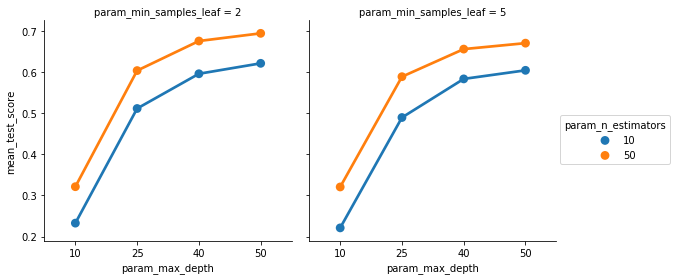

In [11]:
sns.factorplot(x='param_max_depth', y='mean_test_score',
               col='param_min_samples_leaf',
               hue='param_n_estimators',
               data=scores);

In [32]:
y_pred=gscv.best_estimator_.predict(X_test)

best_score = macro_score(y_pred, y_test)

print('f1 score of best estimator: ', best_score[0])
print('precision of best estimator: ', best_score[1])
print('recall of best estimator: ', best_score[2])

c:\users\philippkanehl\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


f1 score of best estimator:  0.7071695102159151
precision of best estimator:  0.7042863087284329
recall of best estimator:  0.7351264689458854


c:\users\philippkanehl\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


As shown by the figures, depth and number of the trees favor the score. This is mainly because the 449(-3) zones require so many splits to disaggregate the feature space in all the individual zones. Also, due to the hight signal/noise ratio, regularization plays a minor role as indicated by an overall better score for smaller *min_samples_leaf*. However, Random Forrests require memory as $\propto \mathrm{Num(trees)}\cdot 2^\mathrm{depth}$, putting deeper and larger models out of reach for my mid-class Laptop (8GB) even though the score might increase further.

Let us visualize the scores on zone-level and identify the weak spots of the model with aid of the confusion matrix:

In [43]:
labels=df.zo_name.unique()

cm=confusion_matrix(y_test, y_pred, labels=labels)

In [77]:
sum_true=cm.sum(axis=0)
sum_pred=cm.sum(axis=1)
hits=np.diagonal(cm)

precision=hits/(sum_pred+1e-10)
recall=hits/(sum_true+1e-10)

f1=2.0*precision*recall/(precision+recall+1e-10)

zone_scores=pd.DataFrame(np.hstack([f1.reshape(-1,1), recall.reshape(-1,1), precision.reshape(-1,1)]), index=labels, columns=['f1', 'recall', 'precision'])

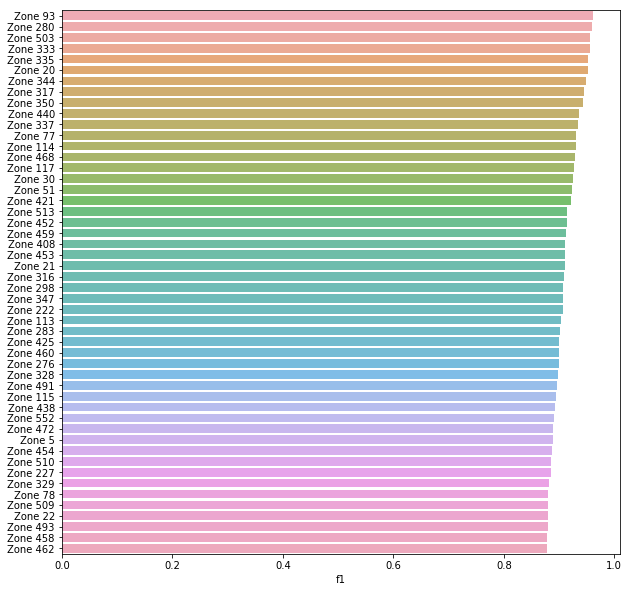

In [79]:
top_50=zone_scores.sort_values('f1', ascending=False).iloc[:50]

plt.figure(figsize=(10,10))
sns.barplot(y=top_50.index, x="f1", data=top_50, alpha=0.8)

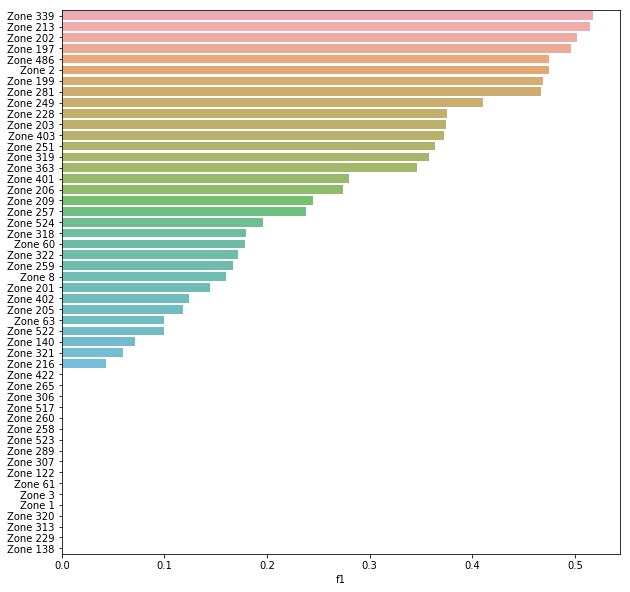

In [88]:
bottom_50=zone_scores.sort_values('f1', ascending=False).iloc[-50:]

plt.figure(figsize=(10,10))
sns.barplot(y=bottom_50.index, x="f1", data=bottom_50, alpha=0.8)

The bottom 50 zones are poorly captured by the model and require additional treatment, e.g., one-vs-rest models, but mainly more data! This becomes evident by measuring the intersection of the 50 least represented zones with 50 poorest predicted zones:

In [91]:
len(bottom_50.index.intersection(df.zo_name.value_counts().index[-50:]))

43

### Shallow Neural Network

Because the simple logistic regression fell just slightly behind the Random Forest Classifier in the Model Pre-Selection Section, it might be worthwhile to investigate a shallow Neural Network which can capture some of the non-linear behavior. To the softmax layer of the multinomial logistic regression two fully connected layers with relu activation are added.

In [22]:
import keras
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.layers import Dropout
from keras.layers.core import Dense, Activation, Lambda, Reshape, Flatten
import logging
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

class IntervalEvaluation(Callback):
    def __init__(self, validation_data=(), interval=10):
        super(Callback, self).__init__()
        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            
            score=f1_score(self.y_val.argmax(axis=-1), y_pred.argmax(axis=-1), average='macro')
            
            print("interval evaluation - epoch: {:d} - f1 score: {:.6f}".format(epoch+1, score))
            
            
model = Sequential()
model.add(Dense(1000, input_dim=X.shape[1], activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(df.zo_name.nunique()-3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 1000)              268000    
_________________________________________________________________
dense_17 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_18 (Dense)             (None, 446)               223446    
Total params: 991,946
Trainable params: 991,946
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, pd.get_dummies(y).values, test_size=0.33, random_state=42, stratify=y.values)

ival = IntervalEvaluation(validation_data=(X_test, y_test), interval=1)

model.fit(X_train, y_train, epochs=20, verbose=1, callbacks=[ival], batch_size=128)

Epoch 1/20
230103/230103 [==============================] - 92s 401us/step - loss: 1.6655 - acc: 0.5310
interval evaluation - epoch: 1 - f1 score: 0.584671
Epoch 2/20
   384/230103 [..............................] - ETA: 1:33 - loss: 1.0658 - acc: 0.6250

c:\users\philippkanehl\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


230103/230103 [==============================] - 94s 410us/step - loss: 0.9759 - acc: 0.66206s - 
interval evaluation - epoch: 2 - f1 score: 0.628859
Epoch 3/20
230103/230103 [==============================] - 93s 404us/step - loss: 0.8687 - acc: 0.69611s - loss: 0
interval evaluation - epoch: 3 - f1 score: 0.646124
Epoch 4/20
230103/230103 [==============================] - 92s 400us/step - loss: 0.8061 - acc: 0.7157
interval evaluation - epoch: 4 - f1 score: 0.662036
Epoch 5/20
230103/230103 [==============================] - 91s 397us/step - loss: 0.7588 - acc: 0.7312
interval evaluation - epoch: 5 - f1 score: 0.677082
Epoch 6/20
230103/230103 [==============================] - 101s 437us/step - loss: 0.7212 - acc: 0.7433
interval evaluation - epoch: 6 - f1 score: 0.682656
Epoch 7/20
230103/230103 [==============================] - 93s 404us/step - loss: 0.6886 - acc: 0.7533
interval evaluation - epoch: 7 - f1 score: 0.679144
Epoch 8/20
230103/230103 [==============================]

After 20 epochs the untuned Neural Network can keep up with the optimized Random Forest Classifier (RFC) in terms of average F1 score. Moreover, with less than 1M neurons the memory consumption is much smaller than that of the RFC, and prediction times significantly faster respectively. Definitely worth a closer look for an extensive hyper-parameter study :-) But unfortunately out of my scope.

## Next Steps

What can be done to further impove the score:
- **ensembling of different models:** because model scores were not too far apart (see model pre-selection), different models (tree based, linear, neural network) can be blended or combined using a super learner to reduce overfitting
- **more features:** more features can be added due to, e.g., signal binning, adding categorical mac_id
- **gather more data:** more data is always better 

More importantly for the further progression than the naked F1 score is the business idea behind the live tracking. Answering the question: Is it more important to capture correctly on zone-level (macro average of scores) if for example the data is sold to each retailer within the mall individually, or on customer level (micro average; possible class inbalances) classifying as many customers correctly as possible?

Thank you for sharing this challenge with me :-)